# Trabajo Práctico 2

####Grupo 1:


| Nombre  | Padrón |
| ------------- | ------------- |
| Alvarez Ernesto Severino | 102221  |
| Feijóo Sofía  | 101148  |
| Milhas Facundo  | 102727 |
| Reinaudo Dante  | 102848  |



# Ejercicio 1

En este ejercicio retomaremos el trabajo presentado en el TP 1 “Queuing theory application in imaging service analysis for small Earth observation satellites”.
Se pide simular los resultados obtenidos sobre la longitud de imágenes en cola esperando ser procesadas en la sección 3.1. “Pure image capture service system” de las siguientes formas:

- Utilizando programación tradicional y el generador de número al azar del tp 1
- Utilizando Simpy

Comparar los resultados obtenidos

### Generador de numeros pseudoaleatorios de Mersenne Twister


In [ ]:
# A continuacion agregaremos nuevamente el generador de numeros psuedoaleatorios de Mersenne Twister utilizado en el primer trabajo practico
# Lo primero que hay que definir son las constantes, estas tienen que ser numeros especificos que en su conjunto cumplen una serie de propiedades.
# Utilizaremos las constantes del MT19937 para esta prueba, que genera numeros pseudo-aleatorios en un rango entre 0 y 2^32 .

n = 624
m = 397
r = 31
f = 1812433253
a = 0x9908B0DF
w = 32
u = 11
s = 7
b = 0x9D2C5680
t = 15
c = 0xEFC60000
l = 18
d = 0xFFFFFFFF
w_mask = pow(2, w) - 1

In [ ]:
# En  primer lugar procederemos a importar las librerias a utilizar
import sys
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [ ]:
# Generamos la palabra(MT) que se utiliza de semilla para el generador
MT = [0 for i in range(n)]
index = n + 1
lower_mask = (1 << r) - 1
upper_mask = (~lower_mask) & w_mask

In [ ]:
# Generamos la semilla o seed y la seteamos
def set_seed(seed):
  global index
  global MT
  index = n
  MT[0] = seed
  for i in range(1, n):
    MT[i] = (f * (MT[i - 1] ^ (MT[i - 1] >> (w - 2))) + i) & w_mask

set_seed(0)

In [ ]:
# Cada vez que llamamos a la funcion *twist* estamos generando los siguiente n valores de la serie Xi
def twist():
  global index
  global MT
  for i in range(n):
    x = (MT[i] & upper_mask) | (MT[(i + 1) % n] & lower_mask)
    xA = x >> 1
    if x % 2 != 0:
      xA = xA^a
    MT[i] = MT[(i + m) % n]^xA
  index = 0


In [ ]:
# Por último el generador de numeros aleatorios que utiliza la posicion del indice actual en la palabra MT para generar el número

def random_number():
  global index
  global MT
  if index == n: twist()
  y = MT[index]
  y = y ^ ((y >> u) & d)
  y = y ^ ((y << s) & b)
  y = y ^ ((y << t) & c)
  y = y ^ (y >> l)

  index += 1
  return y & w_mask


random_number()

2357136044

In [ ]:
# Ademas se adjunta la siguiente funcion para generar numeros alaeatorios entre 0 y 1

def generador_01():
  return random_number() / (pow(2, w) - 1)

### Performance Modelling of Imaging Service of Earth Observation Satellites



A continuacion se procedera a describir el modelo utilizado para simular el procesamiento de captura de imagenes descriptos en las secciones 2 y 3 del paper.

El satelite cuenta con dos colas, una de request recibidas para la caputra de imagenes y otra cola con las imagenes procesadas. La primera tiene una politica de scheduling de FOFS (First Oportunity First Served), en la que los request seran procesados en funcion de la cercania con la ubicacion a fotografiar, mientas que la segunda tiene una politica FCFS (Firs Come First Served) en la que se desencolan las imagenes de acuerdo a las que primero ingresaron en la cola.

Para llevar a cabo la simulacion, se modelo que los request arriban con una dstribucion de Poisson, los cuales se van encolando con una politica FCFS, mientras que el tiempo de procesamiento se modela con una distribucion exponencial con media 1/ n * uo, siendo n la cantidad de request en la cola y uo un parametro determinado.

### Simulación con programacion tradicional y generador MT

In [ ]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# En primer lugar realizaremos un generador de numeros pseudo aleatorios con distribucion exponencial a partir de el generador utilizado en el tp1
def generador_exponencial(media):
    u = generador_01()  # Genera un número aleatorio entre 0 y 1
    x = - media * math.log(1 - u)  # Aplica la transformada inversa de la distribución exponencial
    return x


In [ ]:
arrival_rate = 2
media = 1 / arrival_rate
cantidad_arribos = 1000

# Genera el vector de tiempos de arribo utilizando la función generar_exponencial()
arribos = np.array([generador_exponencial(media) for _ in range(cantidad_arribos)])
arribos_ordenados = sorted(arribos)
total_arribos = np.arange(0,cantidad_arribos)

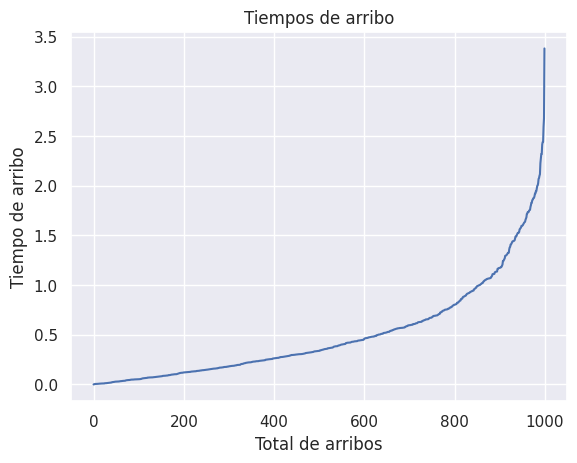

In [ ]:
# Grafica el vector de tiempos de arribo
plt.plot(arribos_ordenados)
plt.title('Tiempos de arribo')
plt.xlabel('Total de arribos')
plt.ylabel('Tiempo de arribo')
plt.show()

In [ ]:
def generar_request(lam):
    return generador_exponencial(1/lam)

In [ ]:
arrival_rate = 2
media = 1 / arrival_rate
cantidad_arribos = 1000
u0 = 0.5

# Genera el vector de tiempos de arribo utilizando la función generar_exponencial()
arribos = np.array([generar_request(arrival_rate) for _ in range(cantidad_arribos)])


In [ ]:
def generar_tiempo_arribos(arribos):
  tiempo_entre_arribos = []
  for idx, x in enumerate(arribos):
      if idx != 0:
        tiempo_entre_arribos.append(tiempo_entre_arribos[idx-1] + x)
      else:
        tiempo_entre_arribos.append(x)
  return tiempo_entre_arribos

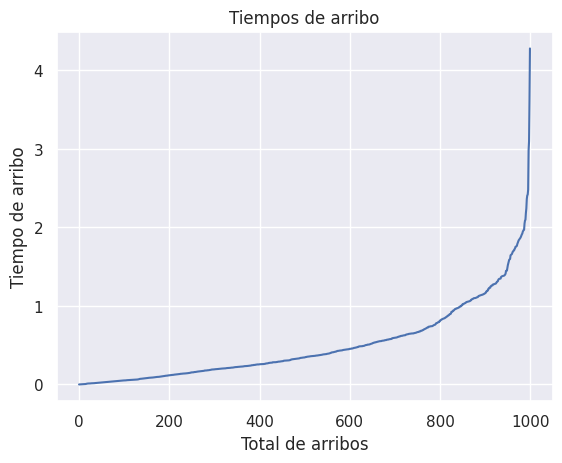

In [ ]:
# Grafica el vector de tiempos de arribo
plt.plot(sorted(arribos))
plt.title('Tiempos de arribo')
plt.xlabel('Total de arribos')
plt.ylabel('Tiempo de arribo')
plt.show()

In [ ]:
def procesar_request(queue_length,u0):
  return generador_exponencial(1 / (queue_length * u0))


In [ ]:
def longitud_por_tiempo(queue, tiempo):
  queue_por_tiempo = []
  end = False
  cont = 0
  while not end and cont < len(queue):
    if queue[cont] <= tiempo:
      queue_por_tiempo.append(queue[cont])
      cont +=1
    else :
      end = True
  return len(queue_por_tiempo)


In [ ]:
def generar_arribos(arrival_rate, cant_arribos):
  cola = []
  for _ in range(cant_arribos):
    llegada = generar_request(arrival_rate)
    cola.append(llegada)
  return cola

In [ ]:
def simulacion_tradicional(arrival_rate,u0,cant_arribos):

  longitudes = []
  procesamiento = []
  tiempo = 0
  tiempos = []
  cola = generar_arribos(arrival_rate,cant_arribos)
  tiempo_arribos = generar_tiempo_arribos(cola)

  tiempo_arribos_return = tiempo_arribos[:]
  cola_return = cola [:]

  while (len(cola)) > 0:
    request = cola.pop(0)
    t_arribo = tiempo_arribos[0]
    if tiempo == 0 or t_arribo > tiempo:
      tiempo = t_arribo

    longitud_actual = longitud_por_tiempo(tiempo_arribos,tiempo)

    longitudes.append(longitud_actual)
    tiempo_procesamiento = procesar_request(longitud_actual,u0)
    procesamiento.append(tiempo_procesamiento)
    tiempo_arribos.pop(0)
    tiempo += tiempo_procesamiento
    tiempos.append(tiempo)


  return tiempo,longitudes,cola_return,tiempo_arribos_return,procesamiento,tiempos




In [ ]:
def mean_queue_length(lengths):
  return sum(lengths) / len(lengths)

In [ ]:
def probability(arrival_rate,n , u0):
  return arrival_rate / (n * u0)

In [ ]:
def queue_length_probability(arrival_rate,n,u0,j):
  p = probability(arrival_rate,n,u0)
  return (1 - p) * (p ** j)

In [ ]:
def generate_graphic(arrival_rate,n,u0):
  lista = []
  for i in range(1,20):
    lista.append(queue_length_probability(arrival_rate,n,u0,i))
  return lista

In [ ]:
def mean_times(times):
  mean = []
  for idx,i in enumerate(times):
    if idx == 0:
      mean.append(i)
    else:
      mean.append(i - times[idx-1])
  return mean

In [ ]:
def queue_mean_length_time(longitudes,tiempo,tiempos):
  mean_time = mean_times(tiempos)
  mean_queue_length = np.zeros(40)
  for idx,i in enumerate(longitudes):
    mean_queue_length[i] += mean_time[idx]
  for idx,i in enumerate(mean_queue_length):
    mean_queue_length[idx] = i / tiempo
  return mean_queue_length


In [ ]:
arrival_rate = 2
u0 = 0.5
cant_arribos = 1000
tiempo,longitudes,cola,arribos,procesamiento,tiempos = simulacion_tradicional(arrival_rate,u0,cant_arribos)
n = mean_queue_length(longitudes)

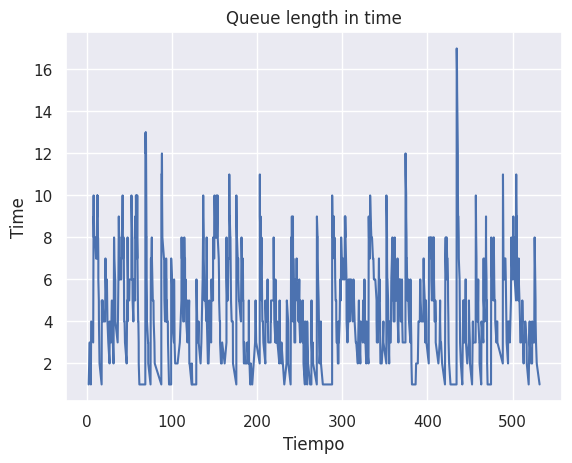

In [ ]:
plt.plot(tiempos,longitudes)
plt.title('Queue length in time')
plt.xlabel('Tiempo')
plt.ylabel('Time')
plt.show()

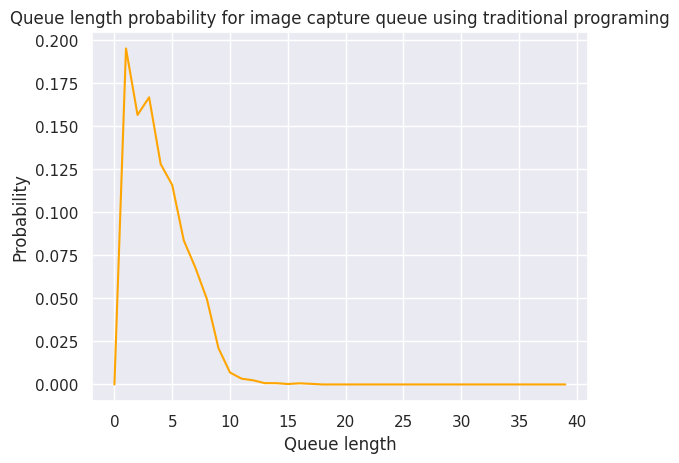

In [ ]:
mean_time  = queue_mean_length_time(longitudes,tiempo,tiempos)
plt.plot(mean_time,color="orange")
plt.title('Queue length probability for image capture queue using traditional programing')
plt.xlabel('Queue length')
plt.ylabel('Probability')
plt.show()

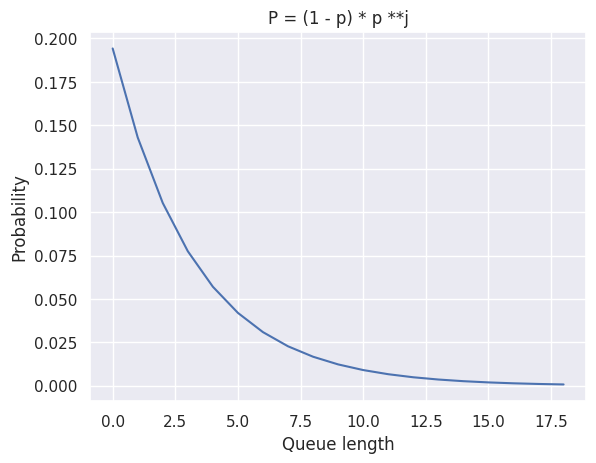

In [ ]:
# Grafica el vector de tiempos de arribo
n = mean_queue_length(longitudes)
lista = generate_graphic(arrival_rate,n,u0)
plt.plot(lista)
plt.title('P = (1 - p) * p **j')
plt.xlabel('Queue length')
plt.ylabel('Probability')
plt.show()

### Simualción con Simpy

In [ ]:
pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import simpy
import random

In [ ]:
class Servidor:
    def __init__(self, env, u0):
        self.env = env
        self.servidor = simpy.Resource(env, capacity=1)
        self.u0 = u0

    def procesar_solicitud(self, solicitud,lengths,times):
        lengths.append(len(self.servidor.queue) + 1)
        tiempo_procesamiento = random.expovariate(self.u0 * (len(self.servidor.queue) + 1))
        yield self.env.timeout(tiempo_procesamiento)
        times.append(self.env.now)

In [ ]:
def llegada_solicitudes(env, servidor,cant_request,lam,lengths,times):
    for i in range(cant_request):
        solicitud = i + 1
        yield env.timeout(random.expovariate(lam))
        env.process(atender_solicitud(env, servidor, solicitud,lengths,times))


In [ ]:
def atender_solicitud(env, servidor, solicitud,lengths,times):
    with servidor.servidor.request() as req:
        yield req
        yield env.process(servidor.procesar_solicitud(solicitud,lengths,times))

In [ ]:
longitudes = []
tiempos = []

arrival_rate = 2
u0 = 0.5
cant_request = 1000

env = simpy.Environment()
servidor = Servidor(env, u0)
env.process(llegada_solicitudes(env, servidor,cant_request,arrival_rate,longitudes,tiempos))
env.run()

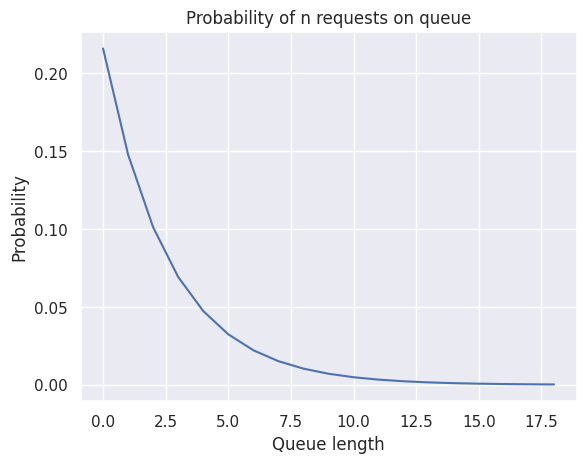

In [ ]:
# Grafica el vector de tiempos de arribo
n = mean_queue_length(longitudes)
lista = generate_graphic(arrival_rate,n,u0)
plt.plot(lista)
plt.title('Probability of n requests on queue')
plt.xlabel('Queue length')
plt.ylabel('Probability')
plt.show()

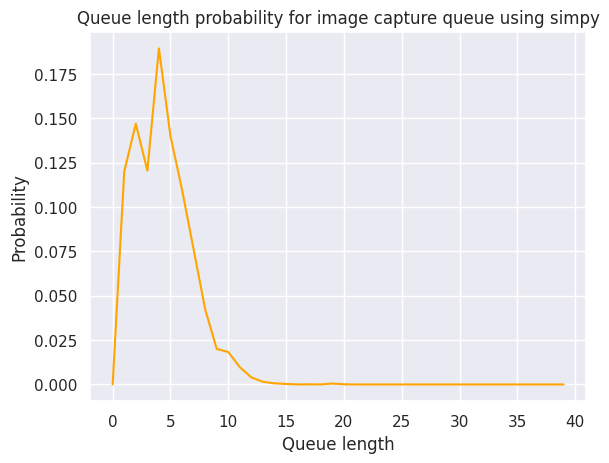

In [ ]:
mean_time  = queue_mean_length_time(longitudes,tiempos[-1],tiempos)
plt.plot(mean_time,color="orange")
plt.title('Queue length probability for image capture queue using simpy')
plt.xlabel('Queue length')
plt.ylabel('Probability')
plt.show()

# Ejercicio 2

Solicitudes arriban a un centro de procesamiento siguiendo un proceso Poisson con una frecuencia media de 10 por minuto. Son puestas en un buffer siguiendo una política FIFO, para ser procesadas por una de las dos máquinas disponibles.

Las 2 máquinas son iguales, y trabajan en paralelo. Cada una sólo puede procesar una solicitud por vez. El tiempo de procesamiento sigue una distribución exponencial con media de 10 segundos por solicitud.
Se pide:
- Factor de ocupación del sistema.
- Cantidad media de solicitudes en el buffer
- Cantidad media de solicitudes en el sistema
- Tiempo medio que las solicitudes están en el buffer
- Tiempo medio de solicitudes en el sistema
- Determinar el tamaña del buffer para que la probabilidad de que haya lugar para recibir solicitudes sea
como mucho 3%.
- Evaluar la posibilidad de reemplazar las dos máquinas por una sola que procesa todos las solicitudes en
un tiempo fijo de 5 segundos. Si el costo de tener solicitudes en el buffer es 0,2 USD/minuto y el costo
de modificar la máquina es 2000 USD, Cuánto tiempo tomará amortizar el inversión?

Simular utilizando Simpy o programación tradicional a elección.

###Distribuciones

####Proceso de Poisson
Se trata de un proceso estocástico que describe eventos aleatorios que ocurren a lo largo del tiempo de manera independiente y a una tasa constante promedio, y sirve para modelar arribo de eventos, y en este caso particular, arribos de requests a un sistema.

La fórmula para el proceso de Poisson se expresa de la siguiente manera:

Poi(λ)=P(λ,x) = ((λ)^x * e^(-λ)) / x!

Donde:
*  P es la probabilidad de que ocurran exactamente "x" cantidad de eventos en un intervalo de tiempo.
*  λ es la la frecuencia de los arribos (en nuestro caso 10/min), es decir, la tasa promedio de eventos por unidad de tiempo.




####Distribución exponencial
Esta distribución de probabilidad continua se utiliza para modelar el tiempo que transcurre entre eventos en un proceso de Poisson, es decir, se usa para modelar el tiempo entre arribos. Esta distribución se caracteriza por tener una tasa de llegada constante y la propiedad de falta de memoria.

La fórmula de la distribución exponencial se expresa de la siguiente manera:

ε(x) = λ * e^(-λx)

Donde:
*   ε(x) es la función de densidad de probabilidad que representa la probabilidad de que el tiempo transcurrido entre eventos sea "x".
*   λ es el tiempo promedio entre arribos, en nuestro caso, el tiempo promedio que le toma a cada máquina procesar una solicitud,  10 segundos.



###Métricas

####Factor de ocupación del sistema
Es una medida de la utilización promedio de las máquinas o recursos disponibles en el sistema. En este caso, se refiere a la proporción promedio del tiempo en el que las máquinas están ocupadas procesando solicitudes.

En la simulación, el factor de ocupación del sistema se calcula dividiendo la suma de los tiempos de las solicitudes en el sistema entre el tiempo total de simulación multiplicado por el número de máquinas disponibles. La fórmula sería:

Factor de ocupación del sistema = (suma de tiempos de solicitudes en el sistema) / (tiempo total de simulación * número de máquinas)

El resultado del cálculo del factor de ocupación del sistema es un valor entre 0 y 1. Un factor de ocupación cercano a 1 indica que las máquinas están muy ocupadas, mientras que un factor de ocupación cercano a 0 indica que las máquinas están subutilizadas.

####Cantidad media de solicitudes
La cantidad media de solicitudes se refiere al promedio de solicitudes que se encuentran esperando en un determinado momento. En otras palabras, es la cantidad promedio de solicitudes que aún no han sido procesadas y están esperando su turno.

*   En el buffer:
  En la simulación, la cantidad media de solicitudes en el buffer se calcula promediando las cantidades de solicitudes en el buffer en cada momento dado. Es decir, se almacenan cantidades de solicitudes en el buffer en instantes dados y se promedian.

*   En el sistema:

  Es la suma de la cantidad media de solicitudes en el buffer y la cantidad media de solicitudes siendo procesadas por las máquinas.

  En la simulación, se almacenan cantidades totales de solicitudes tanto en el buffer como en las maquinas en instantes dados y se promedian.


El resultado del cálculo de la cantidad media de solicitudes es un número real que representa la cantidad promedio de solicitudes en espera en cualquier momento dado.
  



####Tiempo medio de solicitudes
El tiempo medio de solicitudes se refiere a la cantidad promedio de tiempo que una solicitud pasa antes de ser procesada. Es una medida del tiempo de espera promedio.


*   En el buffer:
  En la simulación, el tiempo medio de solicitudes en el buffer se calcula sumando todos los tiempos que las solicitudes pasan en el buffer y dividiéndolo entre la cantidad total de solicitudes que pasaron por el buffer. La fórmula sería:

  Tiempo medio de solicitudes en el buffer = (suma de tiempos de solicitudes en el buffer) / cantidad de solicitudes en el buffer

*   En el sistema:
  Se calcula sumando todos los tiempos que las solicitudes pasan en el sistema (en el buffer y siendo procesadas) y dividiéndolo entre la cantidad total de solicitudes que pasaron por el sistema. La fórmula sería:

  Tiempo medio de solicitudes en el sistema = (suma de tiempos de solicitudes en el sistema) / cantidad de solicitudes en el sistema

El resultado del cálculo del tiempo medio de solicitudes es un número real que representa la cantidad promedio de tiempo que las solicitudes esperan antes de ser procesadas.



####Tamaño del buffer
Se pide determinar el tamaña del buffer para que la probabilidad de que haya lugar para recibir solicitudes sea
como mucho 3%:

Debemos considerar la distribución de llegada de las solicitudes y la capacidad máxima del buffer: La llegada de solicitudes sigue un proceso de Poisson con una frecuencia media de 10 por minuto.

La probabilidad de que haya lugar para recibir solicitudes en el buffer se puede calcular utilizando la distribución de Poisson acumulativa. La probabilidad de que el número de solicitudes que lleguen en un intervalo de tiempo sea menor o igual que la capacidad del buffer (número de lugares disponibles) nos dará la probabilidad deseada.

Aquí está el cálculo correspondiente:

In [ ]:
import math

probabilidad_lugar = 0.03  # Probabilidad máxima de que haya lugar para recibir solicitudes
frecuencia_media = 10  # Frecuencia media de llegada de solicitudes por minuto

tamano_buffer = 0
probabilidad_acumulada = 0

while probabilidad_acumulada < probabilidad_lugar:
    tamano_buffer += 1
    probabilidad_acumulada = sum([math.exp(-frecuencia_media) * (frecuencia_media ** k) / math.factorial(k) for k in range(tamano_buffer)])
    print(probabilidad_acumulada)

print("Tamaño del buffer para una probabilidad máxima del 3%:", tamano_buffer)


4.5399929762484854e-05
0.0004993992273873334
0.0027693957155115762
0.010336050675925718
0.029252688076961072
0.06708596287903178
Tamaño del buffer para una probabilidad máxima del 3%: 6


###Simulación con Sympy

* Componentes Activos: son los que "llegan, usan algunos recursos y se van". En nuestro caso serán las **solicitudes** (interactúan con el ambiente  y con los otros componentes mediante eventos).

* Componentes pasivos o recursos: los que serán "usados por los activos". En nuestro caso serán el buffer y las máquinas.




In [ ]:
!pip install -U simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import simpy
import random

# Parámetros de la simulación
tiempo_simulacion = 1000  # Tiempo total de simulación en minutos
frecuencia_media = 10  # Frecuencia media de llegada de solicitudes por minuto
tiempo_procesamiento_medio = 10  # Tiempo medio de procesamiento en segundos

class Sistema:
    def __init__(self, env, num_maquinas):
        self.env = env
        self.buffer = simpy.Store(env)
        self.maquinas = simpy.Resource(env, num_maquinas)

        self.tiempo_llegada_buffer = 0
        self.tiempo_salida_buffer = 0
        self.tiempos_salida_sistema = 0

        self.tiempos_en_buffer = []
        self.tiempos_en_sistema = []
        self.tiempo_total_en_sistema = 0

        self.  = []
        self.solicitudes_en_sistema = []

        self.cantidad_en_buffer_momento_dado = []
        self.cantidad_en_sistema_momento_dado = []

    def procesar_solicitud(self, solicitud):
        yield self.buffer.put(solicitud)


        with self.maquinas.request() as maquina:
            yield maquina
            self.tiempo_salida_buffer = self.env.now
            tiempo_en_buffer = self.tiempo_salida_buffer - self.tiempo_llegada_buffer
            self.tiempos_en_buffer.append(tiempo_en_buffer)

            self.cantidad_en_buffer_momento_dado.append(len(self.solicitudes_en_buffer))
            self.solicitudes_en_buffer.remove(solicitud)
            yield self.env.timeout(random.expovariate(1 / tiempo_procesamiento_medio))

        self.tiempo_salida_sistema = self.env.now
        tiempo_en_sistema = self.tiempo_salida_sistema - self.tiempo_llegada_buffer
        self.tiempos_en_sistema.append(tiempo_en_sistema)
        self.tiempo_total_en_sistema += tiempo_en_sistema
        self.cantidad_en_sistema_momento_dado.append(len(self.solicitudes_en_sistema))
        self.solicitudes_en_sistema.remove(solicitud)

        print("Solicitud procesada:", solicitud, "tiempo:", self.env.now)

    def llegada_solicitudes(self):
        contador = 0
        while True:
            self.tiempo_llegada_buffer = self.env.now
            yield self.env.timeout(random.expovariate(1 / frecuencia_media))
            contador += 1
            solicitud = "Solicitud %d" % contador
            print("Nueva solicitud:", solicitud, "tiempo:", self.env.now)
            self.solicitudes_en_buffer.append(solicitud)
            self.solicitudes_en_sistema.append(solicitud)
            self.env.process(self.procesar_solicitud(solicitud))

    def calcular_metricas(self):

        cantidad_solicitudes_buffer = sum(self.cantidad_en_buffer_momento_dado)/len(self.cantidad_en_buffer_momento_dado)
        cantidad_solicitudes_sistema = sum(self.cantidad_en_sistema_momento_dado)/len(self.cantidad_en_sistema_momento_dado)
        factor_ocupacion = self.tiempo_total_en_sistema / (self.env.now * 2)
        tiempo_medio_en_buffer = sum(self.tiempos_en_buffer)/len(self.tiempos_en_buffer)
        tiempo_medio_en_sistema =sum(self.tiempos_en_sistema)/len(self.tiempos_en_sistema)

        print("Factor de ocupación del sistema:", factor_ocupacion)
        print("Cantidad media de solicitudes en el buffer:", cantidad_solicitudes_buffer)
        print("Cantidad media de solicitudes en el sistema:", cantidad_solicitudes_sistema)
        print("Tiempo medio que las solicitudes están en el buffer:", tiempo_medio_en_buffer)
        print("Tiempo medio de solicitudes en el sistema:", tiempo_medio_en_sistema)

def simulacion():
    env = simpy.Environment()

    sistema = Sistema(env, num_maquinas=2)

    env.process(sistema.llegada_solicitudes())

    env.run(until=tiempo_simulacion)

    sistema.calcular_metricas()

simulacion()


Nueva solicitud: Solicitud 1 tiempo: 9.38664265912891
Nueva solicitud: Solicitud 2 tiempo: 10.074533347037699
Solicitud procesada: Solicitud 1 tiempo: 11.972472874738191
Solicitud procesada: Solicitud 2 tiempo: 12.797627521513245
Nueva solicitud: Solicitud 3 tiempo: 25.4847472734658
Nueva solicitud: Solicitud 4 tiempo: 32.2829763459553
Nueva solicitud: Solicitud 5 tiempo: 33.20576610772809
Solicitud procesada: Solicitud 3 tiempo: 41.68158225328125
Solicitud procesada: Solicitud 5 tiempo: 46.603464429920734
Solicitud procesada: Solicitud 4 tiempo: 50.638459386395645
Nueva solicitud: Solicitud 6 tiempo: 69.46307032482949
Solicitud procesada: Solicitud 6 tiempo: 99.12741742556305
Nueva solicitud: Solicitud 7 tiempo: 104.39762586714454
Nueva solicitud: Solicitud 8 tiempo: 105.98388693406298
Solicitud procesada: Solicitud 7 tiempo: 109.04546690117327
Solicitud procesada: Solicitud 8 tiempo: 110.13066158711658
Nueva solicitud: Solicitud 9 tiempo: 114.8089691604132
Solicitud procesada: Solici

####Ejercicio a partir de la simulación
"Evaluar la posibilidad de reemplazar las dos máquinas por una sola que procesa todos las solicitudes en
un tiempo fijo de 5 segundos. Si el costo de tener solicitudes en el buffer es 0,2 USD/minuto y el costo de modificar la máquina es 2000 USD, Cuánto tiempo tomará amortizar el inversión?"

Pasos a seguir:
* Simular varias veces hasta llegar a cubrir el valor de 2000usd.
* Observar cuanto tiempo pasó en el cual llegamos a ese valor.
* Sacando un promedio de todas las simulaciones, ese será el tiempo que le tomará al sistema en amortizar la inversión.

In [ ]:
import simpy
import random

# Parámetros de la simulación
tiempo_simulacion = 60000  # Tiempo total de simulación en minutos
frecuencia_media = 10  # Frecuencia media de llegada de solicitudes por minuto
tiempo_procesamiento = 5  # Tiempo medio de procesamiento en segundos

class Sistema:
    def __init__(self, env):
        self.env = env
        self.buffer = simpy.Store(env)
        self.maquinas = simpy.Resource(env)

        self.tiempo_llegada_buffer = 0
        self.tiempo_salida_buffer = 0

        self.gastos = 0




    def procesar_solicitud(self, solicitud):
        yield self.buffer.put(solicitud)


        with self.maquinas.request() as maquina:
            yield maquina
            self.tiempo_salida_buffer = self.env.now
            tiempo_en_buffer = self.tiempo_salida_buffer - self.tiempo_llegada_buffer
            self.gastos += (tiempo_en_buffer * 0.2)
            #Ahora se procesan en 5 segundos
            yield self.env.timeout(tiempo_procesamiento)


    def llegada_solicitudes(self):
        contador = 0
        while True:
            if(self.gastos > 2000):
              tiempo_total_amortizacion =  self.env.now
              print("Los gastos alcanzaron los 2000 usd en tiempo:", tiempo_total_amortizacion)
              break

            else:
              self.tiempo_llegada_buffer = self.env.now
              yield self.env.timeout(random.expovariate(1 / frecuencia_media))
              contador += 1
              solicitud = "Solicitud %d" % contador
              self.env.process(self.procesar_solicitud(solicitud))





def simulacion():

    env = simpy.Environment()

    sistema = Sistema(env)

    env.process(sistema.llegada_solicitudes())

    env.run(until=tiempo_simulacion)


simulacion()







Los gastos alcanzaron los 2000 usd en tiempo: 55017.337477651956


Al correr la simulación repetidas veces obtenemos un promedio de aproximadamente 57400 minutos. Es decir, tomará alrededor de 40 días amortizar el inversión.

# Ejercicio 3

Un centro de distribución posee 4 dársenas de descarga, las cuales pueden utilizarse en paralelo, cada uno con un equipo de operarios. Camiones arriban siguiendo un proceso Poisson con una frecuencia de 5 por hora, si no tienen lugar esperan. El tiempo de descarga sigue una distribución exponencial con media de 30 minutos.
Cada paquete descargado es identificado por un código de barras para luego ser enviado a almacenar.

Se evalúa reemplazar la identificación de códigos de barras por RFID, lo que representaría reducir la media del tiempo de descarga en 5 minutos (manteniendo la misma distribución de probabilidades)

En base a la modificación anterior se propone cerrar una dársena siempre que la media de camiones esperando para descargar no sea superior a 3.

Se pide:
- Simular ambos escenarios utilizando Simpy o programación tradicional.
- Cantidad media de camiones en el sistema
- Cantidad media de camiones en cola
- Tiempo medio de camiones en el sistema
- Tiempo medio de camiones en cola
- Qué recomendación se puede hacer sobre el cierre de la dársena propuesto?

## Funciones

In [ ]:
!pip install -U simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
RANDOM_SEEDS = [1234, 5678, 9012, 3456, 7890]

In [ ]:
import simpy
import pandas as pd
import numpy  as np
from scipy.stats import norm
from scipy.stats import expon

def truck_arrival(env, number_scales, truck_arrival_mean, truck_service_mean):
    next_truck_id = 0
    while True:
       ## exponential distribution for arrivals
       next_truck = expon.rvs(scale = truck_arrival_mean, size = 1)
       # wait for arrival
       yield env.timeout(next_truck)
       time_of_arrival = env.now
       arrivals.append(time_of_arrival)
       length = len(arrivals) - len(departures)
       len_in_system.append(length)
       next_truck_id += 1
       print('%3d llega en %.2f' % (next_truck_id, env.now))

       env.process(unloading(env, number_scales,
                   next_truck_id,time_of_arrival, truck_service_mean))

def unloading(env, scales_lines, truck_number, time_of_arrival, truck_service_mean):
  with scales_lines.request() as req:
    print('%3d entra a la fila en %.2f' %  (truck_number, env.now))
    queue_in = env.now
    length  = len(scales_lines.queue)
    tme_in_queue.append(queue_in)
    len_in_queue.append(length)
    yield req
    print('%3d sale de la fila en %.2f' % (truck_number, env.now))
    queue_out = env.now
    length    = len(scales_lines.queue)
    tme_in_queue.append(queue_out)
    len_in_queue.append(length)
    #exponential distribution for the unloading process
    r_normal = expon.rvs(scale = truck_service_mean, size = 1)
    yield env.timeout(r_normal)
    print('%3d descargando en %.2f' % (truck_number,r_normal))
    print('%3d finalizo en %.2f' % (truck_number, env.now))
    time_of_departure = env.now
    departures.append(time_of_departure)
    time_in_system = time_of_departure - time_of_arrival
    in_system.append(time_in_system)
    time_in_queue = queue_out - queue_in
    in_queue.append(time_in_queue)

In [ ]:
def run(darsenas, seed, time, truck_arrival_mean, truck_service_mean):
  env = simpy.Environment()
  scales_lines = simpy.Resource(env, capacity = darsenas)
  np.random.seed(seed)
  env.process(truck_arrival(env, scales_lines, truck_arrival_mean, truck_service_mean))
  env.run(until = time)

In [ ]:
## average number of trucks in the queue
def avg_line(df_length):
  df_length['delta_time'] = df_length['time'].shift(-1) - df_length['time']
  df_length = df_length[0:-1]  #drop last row because it has infinite delta
  avg = np.average(df_length['len'], weights=df_length['delta_time'])
  return avg

## average number of trucks in the system
def avg_system(df_length):
  df_length['delta_time'] = df_length['arrivals'].shift(-1) - df_length['arrivals']
  df_length = df_length[0:-1]  #drop last row because it has infinite delta
  avg = np.average(df_length['len'], weights=df_length['delta_time'])
  return avg

In [ ]:
def stats(tme_in_queue, len_in_queue, arrivals, len_in_system, in_queue, in_system):
  df1 = pd.DataFrame(tme_in_queue, columns = ['time'])
  df2 = pd.DataFrame(len_in_queue, columns = ['len'])
  df_length = pd.concat([df1, df2], axis = 1)
  avg_length  = avg_line(df_length)
  df3 = pd.DataFrame(arrivals,   columns = ['arrivals'])
  df5 = pd.DataFrame(len_in_system, columns = ['len'])
  df_length2 = pd.concat([df3, df5], axis = 1)
  avg_length2  = avg_system(df_length2)
  avg_delay_inqueue = np.mean(in_queue)
  avg_delay_insyst  = np.mean(in_system)
  print('Tiempo medio de camiones en cola: %.5f'  % (avg_delay_inqueue))
  print('Tiempo medio de camiones en el sistema: %.2f' % (avg_delay_insyst))
  print('Cantidad media de camiones en cola: %.5f' %  (avg_length))
  print('Cantidad media de camiones en el sistema: %.5f' %  (avg_length2))

## Caso 1

Para el primer caso queremos simular con Simpy el arribo de los camiones al centro de distribución, el cual cuenta con 4 dársenas de descarga. Sabemos que los arribos siguen un proceso Poisson con lambda igual a 5, y que el tiempo de descarga sigue una distribución exponencial con media de 30 minutos, por lo que definimos las variables para realizar la simulación.

In [ ]:
DARSENAS = 4
TRUCK_ARRIVAL_MEAN  = 0.2
TRUCK_SERVICE_MEAN  = 0.5
SIM_TIME  = 30
arrivals, departures = [],[]
in_queue, in_system  = [],[]
tme_in_queue, len_in_queue = [],[]
len_in_system = []

In [ ]:
run(DARSENAS, RANDOM_SEEDS[1], SIM_TIME, TRUCK_ARRIVAL_MEAN, TRUCK_SERVICE_MEAN)

  1 llega en 0.13
  1 entra a la fila en 0.13
  1 sale de la fila en 0.13
  2 llega en 0.15
  2 entra a la fila en 0.15
  2 sale de la fila en 0.15
  3 llega en 0.29
  3 entra a la fila en 0.29
  3 sale de la fila en 0.29
  1 descargando en 0.23
  1 finalizo en 0.36
  3 descargando en 0.10
  3 finalizo en 0.39
  4 llega en 0.41
  4 entra a la fila en 0.41
  4 sale de la fila en 0.41
  4 descargando en 0.04
  4 finalizo en 0.44
  5 llega en 0.47
  5 entra a la fila en 0.47
  5 sale de la fila en 0.47
  6 llega en 0.51
  6 entra a la fila en 0.51
  6 sale de la fila en 0.51
  5 descargando en 0.05
  5 finalizo en 0.52
  2 descargando en 0.46
  2 finalizo en 0.60
  6 descargando en 0.11
  6 finalizo en 0.62
  7 llega en 0.78
  7 entra a la fila en 0.78
  7 sale de la fila en 0.78
  8 llega en 1.07
  8 entra a la fila en 1.07
  8 sale de la fila en 1.07
  7 descargando en 0.51
  7 finalizo en 1.29
  9 llega en 1.39
  9 entra a la fila en 1.39
  9 sale de la fila en 1.39
 10 llega en 1.50
 

In [ ]:
stats(tme_in_queue, len_in_queue, arrivals, len_in_system, in_queue, in_system)

Tiempo medio de camiones en cola: 0.08204
Tiempo medio de camiones en el sistema: 0.57
Cantidad media de camiones en cola: 0.41355
Cantidad media de camiones en el sistema: 3.74590


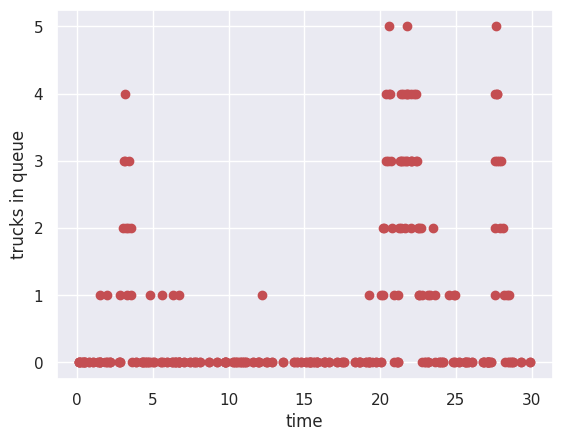

In [ ]:
import matplotlib.pyplot as plt
plt.plot(tme_in_queue, len_in_queue,'ro')
plt.xlabel('time')
plt.ylabel('trucks in queue')
plt.show()

## Caso 2

Para este escenario la media del tiempo de descarga disminuye en 5 minutos y se evalúa utilizar solo 3 dársenas.

In [ ]:
DARSENAS = 3
TRUCK_ARRIVAL_MEAN  = 0.2
TRUCK_SERVICE_MEAN  = 0.42
SIM_TIME  = 30
arrivals, departures = [],[]
in_queue, in_system  = [],[]
tme_in_queue, len_in_queue = [],[]
len_in_system = []

In [ ]:
run(DARSENAS, RANDOM_SEEDS[1], SIM_TIME, TRUCK_ARRIVAL_MEAN, TRUCK_SERVICE_MEAN)

  1 llega en 0.13
  1 entra a la fila en 0.13
  1 sale de la fila en 0.13
  2 llega en 0.15
  2 entra a la fila en 0.15
  2 sale de la fila en 0.15
  3 llega en 0.29
  3 entra a la fila en 0.29
  3 sale de la fila en 0.29
  1 descargando en 0.19
  1 finalizo en 0.33
  3 descargando en 0.08
  3 finalizo en 0.38
  4 llega en 0.41
  4 entra a la fila en 0.41
  4 sale de la fila en 0.41
  4 descargando en 0.03
  4 finalizo en 0.44
  5 llega en 0.47
  5 entra a la fila en 0.47
  5 sale de la fila en 0.47
  5 descargando en 0.04
  5 finalizo en 0.51
  6 llega en 0.51
  6 entra a la fila en 0.51
  6 sale de la fila en 0.51
  2 descargando en 0.38
  2 finalizo en 0.53
  6 descargando en 0.09
  6 finalizo en 0.61
  7 llega en 0.78
  7 entra a la fila en 0.78
  7 sale de la fila en 0.78
  8 llega en 1.07
  8 entra a la fila en 1.07
  8 sale de la fila en 1.07
  7 descargando en 0.43
  7 finalizo en 1.21
  9 llega en 1.39
  9 entra a la fila en 1.39
  9 sale de la fila en 1.39
 10 llega en 1.50
 

In [ ]:
stats(tme_in_queue, len_in_queue, arrivals, len_in_system, in_queue, in_system)

Tiempo medio de camiones en cola: 0.41189
Tiempo medio de camiones en el sistema: 0.83
Cantidad media de camiones en cola: 2.09400
Cantidad media de camiones en el sistema: 5.17359


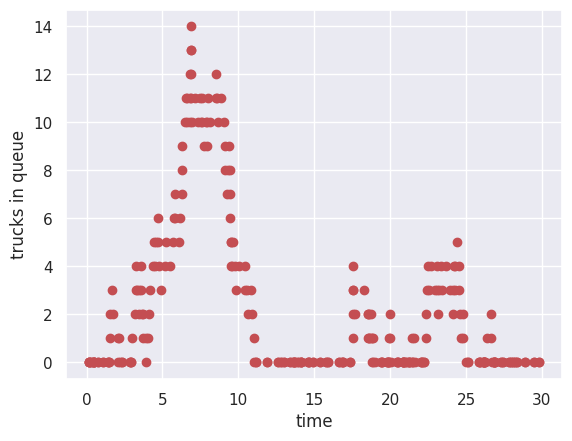

In [ ]:
import matplotlib.pyplot as plt
plt.plot(tme_in_queue, len_in_queue,'ro')
plt.xlabel('time')
plt.ylabel('trucks in queue')
plt.show()

## Conclusión

Podemos observar en los gráficos que si bien la media del tiempo de descarga bajó de 30 a 25 minutos, no bajó lo suficiente como para que eliminar una dársena no tenga tanto impacto en la cola de espera de camiones.

En el primer escenario la cola de espera tiene como máximo 5 camiones, estando en su mayoría del tiempo vacía (es decir, el tiempo de espera para pasar a descarga es nulo). En el segundo escenario podemos notar cómo crecen tanto el tiempo medio de camiones en la cola como la cantidad de los mismos en ella. Si bien el enunciado propone cerrar una dársena siempre que la media de camiones esperando para descargar no sea superior a 3, lo cual está sucediendo en este caso (tenemos una media de 2 aproximadamente), consideramos que no es una buena opción hacer esta modificación ya que impacta significativamente en el tiempo que están en el sistema los camiones. Sería una opción viable si se disminuyera aún algunos minutos más la media del tiempo de descarga.

# Ejercicio 4


Una entidad financiera está analizando cambiar uno de sus cajeros automáticos por uno con la funcionalidad de reciclador de billetes (si un cliente realiza un depósito de efectivo, ese efectivo estará disponible para que lo
pueda retirar otro cliente). El cajero automático actual, que se quiere reemplazar, es de tipo estándar. No recicla los billetes, sino que
posee dos compartimentos, uno con dinero para entregar y otro donde guarda el dinero que se deposita.

Esto presenta los siguientes problemas:

- Si no tiene más efectivo para entregar en el compartimento de retiro de dinero, no entrega efectivo
aunque tenga en el compartimento de depósitos.
- Si el compartimento que recibe los depósitos se completa, no puede recibir más.

La entidad conoce que con el cajero actual el 20% de los clientes se retiraba sin poder extraer dinero, y sólo acepta cambiarlo si este porcentaje disminuye.
Por simplicidad suponer que el cajero sólo expende billetes de $100, tiene una capacidad máxima de 2000 billetes, y comienza el día con su carga completa.

Si un cliente quiere extraer dinero y el cajero no cuenta con la suma suficiente, se va del mismo sin retirar nada.

Algo similar ocurre cuando un cliente desea depositar efectivo y la capacidad máxima de billetes en el cajero fue alcanzada, retirándose sin poder depositar.

En el relevamiento que realizó la entidad diferenció a sus clientes en dos grupos:

- Grupo 1: Sólo retiran efectivo, y corresponden al 75% de los clientes que arriban. El tiempo que utilizan el cajero se puede modelar con una distribución exponencial de media 90 segundos. Cada cliente de este grupo, extrae una cantidad de billetes que sigue una distribución uniforme
[3,50].
- Grupo 2: Sólo realizan depósitos, son el 25% de los clientes totales.
Utilizando el cajero un tiempo que siguen una distribución exponencial de media 5 minutos. Cada cliente de este grupo, deposita una cantidad de billetes que se puede modelar utilizando una distribución uniforme [10,110].

La frecuencia de arribos de clientes es de 1 cliente cada 10 minutos con distribución exponencial.
Se pide:
- a. Simular 1000 días completos de 24 hrs.
- b. Para un día en particular graficar la cantidad de billetes en el cajero luego de cada transacción.
- c. Calcular el tiempo medio que los clientes demoraron en el sistema (espera + utilización del cajero)
- d. ¿Recomienda a la entidad que implemente el cambio de cajero?
El ejercicio se puede resolver utilizando Simpy o programación tradicional (a elección del grupo)

In [ ]:
import simpy
from scipy.stats import expon
import random

In [ ]:
class Cajero(simpy.Resource):

  def __init__(self, env):
    super().__init__(env, capacity=1)
    self.reiniciar_dinero()

  def reiniciar_dinero(self):
    self.plata = 2000

In [ ]:
def arribo_cliente_1(env, cajero):
  global cantidad_de_gente_enojada
  global valores_en_el_tiempo
  global tiempos_de_espera

  tiempo_de_arribo = env.now
  with cajero.request() as caj:
    yield caj

    tiempo_en_cajero = expon.rvs(scale = 90, size = 1)
    yield env.timeout(tiempo_en_cajero)

    cantidad_de_billetes = random.randint(3, 50)
    if (cajero.plata > cantidad_de_billetes):
      cajero.plata -= cantidad_de_billetes
      valores_en_el_tiempo.append(cajero.plata)
      tiempos_de_espera.append(env.now - tiempo_de_arribo)
    else:
      cantidad_de_gente_enojada += 1

def arribo_cliente_2(env, cajero):
  global cantidad_de_gente_enojada
  global valores_en_el_tiempo
  global tiempos_de_espera

  tiempo_de_arribo = env.now
  with cajero.request() as caj:
    yield caj

    tiempo_en_cajero = expon.rvs(scale = 300, size = 1)
    yield env.timeout(tiempo_en_cajero)

    cantidad_de_billetes = random.randint(10, 110)
    if ((cajero.plata + cantidad_de_billetes) < 2000):
      cajero.plata += cantidad_de_billetes
      valores_en_el_tiempo.append(cajero.plata)
      tiempos_de_espera.append(env.now - tiempo_de_arribo)
    else:
      cantidad_de_gente_enojada += 1

def source(env, cajero):
  global cantidad_de_gente
  while True:
    proximo_cliente = expon.rvs(scale = 600, size = 1)
    yield env.timeout(proximo_cliente)
    cantidad_de_gente += 1
    es_cliente_2 = (random.randint(1, 4)) == 1
    if es_cliente_2:
      env.process(arribo_cliente_2(env, cajero))
    else:
      env.process(arribo_cliente_1(env, cajero))


A)

In [ ]:
cantidad_de_gente_enojada = 0
cantidad_de_gente = 0
tiempos_de_espera = []
env = simpy.Environment()
cajero = Cajero(env)
env.process(source(env, cajero))

seconds_in_a_day = 86400
seconds = seconds_in_a_day
for _ in range(1000):
  env.run(until=seconds)
  seconds += seconds_in_a_day
  cajero.reiniciar_dinero()

print("Gente: ", cantidad_de_gente)
print("Gente enojada: ", cantidad_de_gente_enojada)
print("Porcentaje: ", cantidad_de_gente_enojada / cantidad_de_gente)

Gente:  144045
Gente enojada:  2628
Porcentaje:  0.01824429865666979


B)

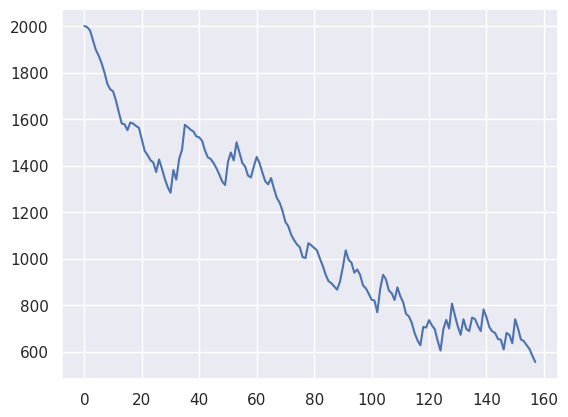

In [ ]:
cantidad_de_gente_enojada = 0
cantidad_de_gente = 0
env = simpy.Environment()
cajero = Cajero(env)
env.process(source(env, cajero))
valores_en_el_tiempo = [2000]

import matplotlib.pyplot as plt

env.run(until=86400)

plt.plot(valores_en_el_tiempo)

C)

In [ ]:
print("tiempo promedio de espera: %f segundos" % (sum(tiempos_de_espera) / len(tiempos_de_espera)))

tiempo promedio de espera: 201.578364 segundos


D)

Si se recomienda utilizar el nuevo cajero ya que pasaria a ser, aproximadamente, un 2% de la gente la que no pueda efectuar su transacción, en comparativa con el cajero anterior que tiene un 20%
